<a href="https://colab.research.google.com/github/SambhaviPD/droughtwatch/blob/main/Bayesian_Sweeps_on_Drought_Watch_Densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install wandb

In [ ]:
!pip install wandb --upgrade

     |████████████████████████████████| 1.8MB 14.4MB/s 
     |████████████████████████████████| 133kB 50.3MB/s 
     |████████████████████████████████| 102kB 12.3MB/s 
     |████████████████████████████████| 174kB 50.6MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=2b06e09765323717fab1cfd2f4224dd4bb20326968d0770561efb1d9325f73f0
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=17b45fb8d8fbb6ee1b247aba3bb4c10588d4a6ec7358e09919c9b4de2f5d1e16
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [ ]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Entire logic of downloading dataset and all process required for train

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import random
import glob
import os
import time
import copy
from pathlib import Path
from itertools import chain
from collections import Counter

# pytorch related imports
import random

from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from tqdm.notebook import tqdm

In [ ]:
print("PyTorch version: ", torch.__version__)
print("Torchvision version: ", torchvision.__version__)

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PyTorch version:  1.8.1+cu101
Torchvision version:  0.9.1+cu101


In [ ]:
# Initial setup per Readme in https://github.com/wandb/droughtwatch

# clone the repository
!git clone https://github.com/wandb/droughtwatch.git

# install wandb
!pip install wandb

%cd droughtwatch

# Download train and validation data
!bash download_data.sh

Cloning into 'droughtwatch'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 113 (delta 0), reused 1 (delta 0), pack-reused 110
Receiving objects: 100% (113/113), 7.52 MiB | 19.01 MiB/s, done.
Resolving deltas: 100% (55/55), done.
/content/droughtwatch
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2050M  100 2050M    0     0  74.2M      0  0:00:27  0:00:27 --:--:-- 90.4M
Archive:  dw_data.zip
   creating: droughtwatch_data/
   creating: droughtwatch_data/val/
  inflating: droughtwatch_data/val/part-r-00090  
  inflating: droughtwatch_data/val/part-r-00061  
  inflating: droughtwatch_data/val/part-r-00052  
  inflating: droughtwatch_data/val/part-r-00043  
  inflating: droughtwatch_data/val/part-r-00040  
  inflating: droughtwatch_data/val/part-r-00042  
  inflating: droughtw

In [ ]:
# Common configuration parameters
train_data_path = 'data/train'
val_data_path = 'data/val'
test_data_path = 'data/test'
data_path = 'data'
folder_path = 'content/droughtwatch'

In [ ]:
label_names = ['0', '1', '2', '3' ]

In [ ]:
# Create folder structure for train
for label in label_names:
  if not os.path.isdir(str(os.path.join(train_data_path, Path(label)))):
    os.makedirs(str(os.path.join(train_data_path, Path(label))))
  else:
    print('{} already exists!'.format(str(os.path.join(train_data_path, Path(label)))))

# Create folder structure for val
for label in label_names:
  if not os.path.isdir(str(os.path.join(val_data_path, Path(label)))):
    os.makedirs(str(os.path.join(val_data_path, Path(label))))
  else:
    print('{} already exists!'.format(str(os.path.join(val_data_path, Path(label)))))

In [ ]:
t0 = os.path.join(train_data_path, label_names[0])
t1 = os.path.join(train_data_path, label_names[1])
t2 = os.path.join(train_data_path, label_names[2])
t3 = os.path.join(train_data_path, label_names[3])

In [ ]:
v0 = os.path.join(val_data_path, label_names[0])
v1 = os.path.join(val_data_path, label_names[1])
v2 = os.path.join(val_data_path, label_names[2])
v3 = os.path.join(val_data_path, label_names[3])

In [ ]:
# Data loading functions

# Function that returns files starting with part-r pattern from folder_path
def filelist(folder_path):
  files = Path(folder_path).glob('**/part-r-*')
  print('Number of TFRecordDatasets in {}: {}'.format(folder_path, len(os.listdir(folder_path))))
  return files

def load_data(data_path):
  train = filelist(train_data_path)
  val = filelist(val_data_path)
  return train, val

# Function that parses TFRecordDataset and returns individual records from the Dataset
def parse_file(file):
  filename = tf.data.TFRecordDataset(str(file))
  # TO DO: change make_one_shot_iterator to tf.v2 version
  iterator = tf.compat.v1.data.make_one_shot_iterator(filename)
  
  features = {
    'B1': tf.io.FixedLenFeature([], tf.string),
    'B2': tf.io.FixedLenFeature([], tf.string),
    'B3': tf.io.FixedLenFeature([], tf.string),
    'B4': tf.io.FixedLenFeature([], tf.string),
    'B5': tf.io.FixedLenFeature([], tf.string),
    'B6': tf.io.FixedLenFeature([], tf.string),
    'B7': tf.io.FixedLenFeature([], tf.string),
    'B8': tf.io.FixedLenFeature([], tf.string),
    'B9': tf.io.FixedLenFeature([], tf.string),
    'B10': tf.io.FixedLenFeature([], tf.string),
    'B11': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
  }

  parsed_files = [tf.io.parse_single_example(data, features) for data in iterator]
  return parsed_files

In [ ]:
# Save TFRecordDataset records to .jpg files in order to proceed with
# Pytorch's data loaders. TO DO: (1) Needto save the images to google drive
# and mount the drive here and proceed rather than executing this
# every time. For the moment proceeding as is.
# (2) Need to see how to manipulate with TFRecordDataset itself. 
# Common configuration parameters
train, val = load_data(data_path)
train_files = []
val_files = []

#%cd 'data/train'
for file in train:
  #print(os.path.basename(file))
  parsed_train_files = parse_file(file)
  train_files.append(parsed_train_files)

for file in val:
  parsed_val_files = parse_file(file)
  val_files.append(parsed_val_files)

print(len(train_files))

Number of TFRecordDatasets in data/train: 405
Number of TFRecordDatasets in data/val: 105
400


Frequency of unique values:
[[    0     1     2     3]
 [51814 12851 13609  8043]]


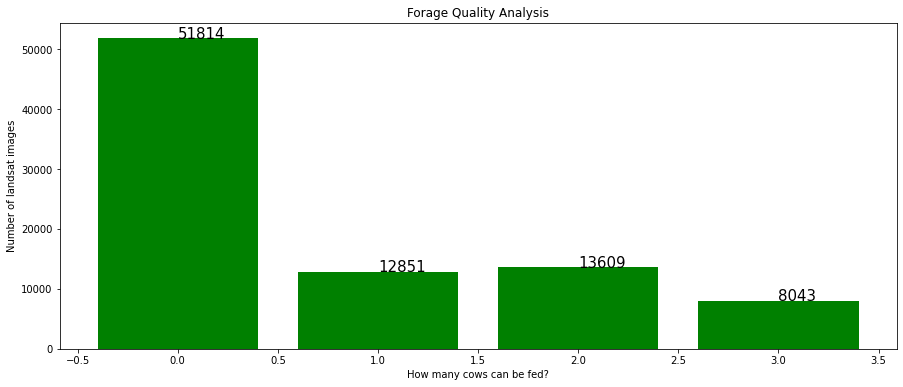

In [ ]:
# Fetch labels from parsed_files
train_labels = np.array([])
for records in train_files:
  labels = tf.cast([ record['label'] for record in records], tf.int32).numpy()
  if train_labels.size == 0:
    train_labels = np.array([labels])
  else:
    train_labels = np.append(train_labels, [labels])

# Calculate unique labels and count of each in entire train folder
unique_elements, counts_elements = np.unique(train_labels, return_counts=True)
print("Frequency of unique values:")
print(np.asarray((unique_elements, counts_elements)))

# Plot a bar chart to show data split 
figure = plt.figure(figsize=(15, 6))
plt.title('Forage Quality Analysis')
plt.xlabel('How many cows can be fed?')
plt.ylabel('Number of landsat images')
plt.bar(unique_elements, counts_elements, color='green')

# To display count of each label
for index, data in enumerate(counts_elements):
  plt.text(x=index, y=data+1, s=f'{data}', fontdict=dict(fontsize=15))
 
figure.show()

Frequency of unique values:
[[   0    1    2    3]
 [6443 1710 1673  952]]


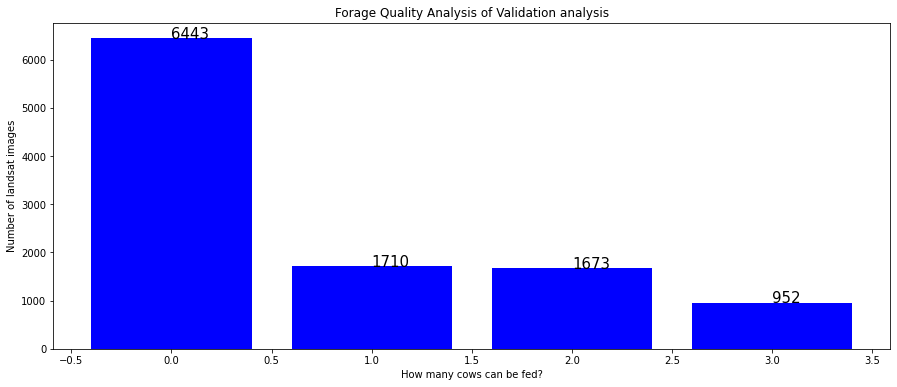

In [ ]:
# Fetch labels from parsed_files - validation data set
val_labels = np.array([])
for records in val_files:
  labels = tf.cast([ record['label'] for record in records], tf.int32).numpy()
  if val_labels.size == 0:
    val_labels = np.array([labels])
  else:
    val_labels = np.append(val_labels, [labels])

# Calculate unique labels and count of each in entire train folder
unique_elements, counts_elements = np.unique(val_labels, return_counts=True)
print("Frequency of unique values:")
print(np.asarray((unique_elements, counts_elements)))

# Plot a bar chart to show data split 
figure = plt.figure(figsize=(15, 6))
plt.title('Forage Quality Analysis of Validation analysis')
plt.xlabel('How many cows can be fed?')
plt.ylabel('Number of landsat images')
plt.bar(unique_elements, counts_elements, color='blue')

# To display count of each label
for index, data in enumerate(counts_elements):
  plt.text(x=index, y=data+1, s=f'{data}', fontdict=dict(fontsize=15))
 
figure.show()

In [ ]:
def get_image_from_example(parsed_example, intensify=True):
  rgbArray = np.zeros((65, 65, 3), 'uint8')
  for i, band in enumerate(['B5', 'B6', 'B7']):
    band_data = np.frombuffer(parsed_example[band].numpy(), dtype=np.uint8)
    band_data = band_data.reshape(65, 65)
    if intensify:
      band_data = band_data/np.max(band_data)*255
    else:
      band_data = band_data*255
    rgbArray[..., i] = band_data

  label = tf.cast(parsed_example['label'], tf.int32).numpy()

  return rgbArray, label

In [ ]:
# One off time
import shutil

# Save files from train as images
cnt = 0
for records in train_files:
  for record in records:
    img, label = get_image_from_example(record)
    filename = 'image-' + str(cnt) + '-label '+ str(label) + '.jpg'
    plt.imsave(filename, img, cmap='gray')
    # Move files to appropriate folders based on their labels
    if label == 0:
      shutil.move(filename, t0)
    elif label == 1:
      shutil.move(filename, t1)
    elif label == 2:
      shutil.move(filename, t2)
    elif label == 3:
      shutil.move(filename, t3)
    else:
      print('Incorrect label')
    cnt += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [ ]:
# Save files from val as images
cnt = 0
for records in val_files:
  for record in records:
    img, label = get_image_from_example(record)
    filename = 'image-' + str(cnt) + '-label '+ str(label) + '.jpg'
    plt.imsave(filename, img, cmap='gray')
    # Move files to appropriate folders based on their labels
    if label == 0:
      shutil.move(filename, v0)
    elif label == 1:
      shutil.move(filename, v1)
    elif label == 2:
      shutil.move(filename, v2)
    elif label == 3:
      shutil.move(filename, v3)
    else:
      print('Incorrect label')
    cnt += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [ ]:
def make(config):
  # make the model - TO DO: will change model details in a bit
  # model = ConvNet(config.kernels, config.classes).to(device)
  model_ft, input_size = initialize_model("densenet", config.classes, feature_extract=True, 
                                          use_pretrained=True)
  # Make the data
  dataloaders = get_data(input_size, config.batch_size)

  # Make the loss and optimizer
  criterion = nn.CrossEntropyLoss()

  return model_ft, dataloaders, criterion

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained):
  model_ft = None
  input_size = 0

  model_ft = models.densenet121(pretrained=use_pretrained)
  set_parameter_requires_grad(model_ft, feature_extract)
  num_ftrs = model_ft.classifier.in_features
  print('num_ftrs: ', num_ftrs)
  model_ft.classifier = nn.Linear(num_ftrs, num_classes)
  input_size = 224
  
  return model_ft, input_size

In [ ]:
def get_data(input_size, batch_size):
  # Data Augmentation and normalization for Training
  # Just normalization for Validation
  data_transforms = {
      'train': transforms.Compose([
          transforms.RandomResizedCrop(input_size),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
      'val': transforms.Compose([
          transforms.Resize(input_size),
          transforms.CenterCrop(input_size),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
  }

  print('Initializing Datasets and DataLoaders...')

  # Create training and validation datasets
  image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x), data_transforms[x]) for x in ['train', 'val']}

  # Create training and validation dataloaders
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                                shuffle=True, num_workers=0) for x in ['train', 'val']}

  print(dataloaders)    
  print(type(dataloaders))                                         

  return dataloaders

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
  if feature_extracting:
    for param in model.parameters():
      param.set_parameter_requires_grad = False

In [ ]:
def create_optimizer(model_ft, optimizer, feature_extract, learning_rate):
  # Gather the parameters to be optimized/updated in this run. If we are
  # finetuning we will be updating all parameters. However, if we are
  # doing feature extract method, we will only update the parameters
  # that we have just initialized, i.e. the parameters with requires_grad
  # is True.
  
  # Send the model to device
  model_ft = model_ft.to(device)
  params_to_update = model_ft.parameters()
  print('Params to learn')
  if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
      if param.requires_grad == True:
        params_to_update.append(param)
        #print('\t', name)
  else:
    for name, param in model_ft.named_parameters():
      if param.requires_grad == True:
        print('\t', name)

  # Observe that all parameters are optimized
  if optimizer == 'sgd':
    optimizer_ft = optim.SGD(params_to_update, lr=learning_rate, momentum=0.9)
  
  elif optimizer == 'adam':
    optimizer_ft = optim.Adam(params_to_update, lr=learning_rate)

  return optimizer_ft

In [ ]:
# Method to handle training and validation of a given model
def train(config=None):
  # tell wandb to watch what the model gets upto: gradients, weights and more!
  # wandb.watch(model, criterion, log="all", log_freq=10)
  with wandb.init(project="sweep-densenet121", config=None):
    # If called by wandb.agent, as below,
    # this config will be set by Sweep Controller
    config = wandb.config

    # make the model, data and optimization parameters
    model, dataloaders, criterion = make(config)

    # final step for finetuning and feature extracting is to create 
    # an optimizer that only updates the desired parameters
    optimizer = create_optimizer(model, config.optimizer, True, config.learning_rate)

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(config.num_epochs):
      print("Epoch - {} / {}".format(epoch, config.num_epochs - 1))
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ["train", "val"]:
        if phase == "train":
          model.train()
        else:
          model.eval()

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        print('phase: {}, device: {}'.format(phase, device))
        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward
          # track history if only in train
          with torch.set_grad_enabled(phase=="train"):
            # get model outputs and calculate loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # backward and optimize only for training phase
            if phase == "train":
              loss.backward()
              optimizer.step()

          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
        # Report metrics to wandb
        if phase == "train":
          wandb.log({"epoch": epoch, "train_loss": epoch_loss, "train_acc": epoch_acc})
        if phase == "val":
          wandb.log({"epoch": epoch, "val_loss":epoch_loss, "val_acc": epoch_acc})

        # deep copy the model
        if phase == "val" and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())
        if phase == "val":
          val_acc_history.append(epoch_acc)

        print()

    print("Best Val Accuracy: {:.4f}".format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    # Save the model
    torch.save(model.state_dict(best_model_wts), "sweeps-densenet121.pt")

    return model, val_acc_history

# End of methods related to train

#Configure the sweep, to start with choose random. Other options are grid and bayesian search.

In [ ]:
sweep_config = {
    'method' : 'bayes'
}

#Define the metric

In [ ]:
metric = {
    'val_loss_metric' : {
        'name' : 'val_loss',
        'goal' : 'minimize',
    },
}

sweep_config['metric'] = metric

#Define parameters

In [ ]:
parameters_dict = {
    'optimizer' : {
        'value' : 'sgd'
    },
    'fc_layer_size' : {
        'values' : [32, 64, 96, 128, 256]
    },
    'dropout' : {
        'value' : 0.4
    },
}

sweep_config['parameters'] = parameters_dict

In [ ]:
parameters_dict.update({
    'num_epochs' : {
        'values' : [5, 10, 15]
    }
})

In [ ]:
import math

parameters_dict.update({
    'learning_rate' : {
        'value' : 0.0004
    },
    'batch_size' : {
        'values': [32, 64, 96, 128]
    },
    'classes' : {
        'value' : 5
    },
})

In [ ]:
def get_sweep_id(method):
    sweep_config = {
        'method': method,
        'metric': {
          'name': 'accuracy',
          'goal': 'maximize'   
        },
        'parameters': {
            'batch_size': {
                'values': [32, 64, 96, 128]
            },
            'num_epochs': {
                'values': [5, 10, 15]
            },
            'classes' : {
                'value' : 5
            },
            'learning_rate' : {
                'value' : 0.0004
            },
            'optimizer' : {
                'value' : 'sgd'
            },
            'fc_layer_size' : {
                'values' : [32, 64, 96, 128, 256]
            },
            'dropout' : {
                'value' : 0.4
            },
        }
    }
    sweep_id = wandb.sweep(sweep_config, project='bayes-sweeps-densenet121')
    
    return sweep_id

In [ ]:
sweep_id = get_sweep_id('bayes')

Create sweep with ID: zyda977e
Sweep URL: https://wandb.ai/prettycold/bayes-sweeps-densenet121/sweeps/zyda977e


In [ ]:
wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: z2zjbmgy with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f53d3e68c90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f53d3e68490>}
<class 'dict'>
Params to learn
Epoch - 0 / 4
----------
phase: train, device: cuda:0
train Loss: 0.9995 Acc: 0.6118

phase: val, device: cuda:0
val Loss: 0.9419 Acc: 0.6262

Epoch - 1 / 4
----------
phase: train, device: cuda:0
train Loss: 0.9363 Acc: 0.6322

phase: val, device: cuda:0
val Loss: 0.8935 Acc: 0.6530

Epoch - 2 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8980 Acc: 0.6523

phase: val, device: cuda:0
val Loss: 0.8479 Acc: 0.6722

Epoch - 3 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8693 Acc: 0.6631

phase: val, device: cuda:0
val Loss: 0.8181 Acc: 0.6877

Epoch - 4 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8440 Acc: 0.6738

phase: val, device: cuda:0
val Loss: 0.8005 Acc: 0.6926

Best Val Accuracy: 0.6926


wandb: Agent Starting Run: 8yt6i37f with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f53ce7a8ed0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f53d3e84f10>}
<class 'dict'>
Params to learn
Epoch - 0 / 9
----------
phase: train, device: cuda:0
train Loss: 1.0025 Acc: 0.6110

phase: val, device: cuda:0
val Loss: 0.9484 Acc: 0.6237

Epoch - 1 / 9
----------
phase: train, device: cuda:0
train Loss: 0.9360 Acc: 0.6329

phase: val, device: cuda:0
val Loss: 0.8977 Acc: 0.6476

Epoch - 2 / 9
----------
phase: train, device: cuda:0
train Loss: 0.9007 Acc: 0.6495

phase: val, device: cuda:0
val Loss: 0.8581 Acc: 0.6630

Epoch - 3 / 9
----------
phase: train, device: cuda:0
train Loss: 0.8722 Acc: 0.6629

phase: val, device: cuda:0
val Loss: 0.8277 Acc: 0.6845

Epoch - 4 / 9
----------
phase: train, device: cuda:0
train Loss: 0.8465 Acc: 0.6717

phase: val, device: cuda:0
val Loss: 0.7944 Acc: 0.6972

Epoch - 5 / 9
----------
phase: train, device:

wandb: Agent Starting Run: 74ulzwvi with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f53cecbb310>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f53cecbbfd0>}
<class 'dict'>
Params to learn
Epoch - 0 / 4
----------
phase: train, device: cuda:0
train Loss: 0.9739 Acc: 0.6214

phase: val, device: cuda:0
val Loss: 0.8762 Acc: 0.6611

Epoch - 1 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8970 Acc: 0.6528

phase: val, device: cuda:0
val Loss: 0.8181 Acc: 0.6806

Epoch - 2 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8503 Acc: 0.6724

phase: val, device: cuda:0
val Loss: 0.7973 Acc: 0.6978

Epoch - 3 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8173 Acc: 0.6856

phase: val, device: cuda:0
val Loss: 0.7333 Acc: 0.7180

Epoch - 4 / 4
----------
phase: train, device: cuda:0
train Loss: 0.7917 Acc: 0.6966

phase: val, device: cuda:0
val Loss: 0.7317 Acc: 0.7209

Best Val Accuracy: 0.7209


wandb: Agent Starting Run: 4qil425l with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f53cf2a4690>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f53cf2a46d0>}
<class 'dict'>
Params to learn
Epoch - 0 / 4
----------
phase: train, device: cuda:0
train Loss: 0.9693 Acc: 0.6236

phase: val, device: cuda:0
val Loss: 0.8807 Acc: 0.6501

Epoch - 1 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8904 Acc: 0.6541

phase: val, device: cuda:0
val Loss: 0.8133 Acc: 0.6826

Epoch - 2 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8481 Acc: 0.6736

phase: val, device: cuda:0
val Loss: 0.7712 Acc: 0.7035

Epoch - 3 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8166 Acc: 0.6868

phase: val, device: cuda:0
val Loss: 0.7493 Acc: 0.7114

Epoch - 4 / 4
----------
phase: train, device: cuda:0
train Loss: 0.7912 Acc: 0.6968

phase: val, device: cuda:0
val Loss: 0.7469 Acc: 0.7144

Best Val Accuracy: 0.7144


wandb: Agent Starting Run: 2dgkj7a3 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f53cec39f10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f53ce7ae390>}
<class 'dict'>
Params to learn
Epoch - 0 / 14
----------
phase: train, device: cuda:0
train Loss: 0.9985 Acc: 0.6119

phase: val, device: cuda:0
val Loss: 0.9501 Acc: 0.6186

Epoch - 1 / 14
----------
phase: train, device: cuda:0
train Loss: 0.9383 Acc: 0.6330

phase: val, device: cuda:0
val Loss: 0.9129 Acc: 0.6431

Epoch - 2 / 14
----------
phase: train, device: cuda:0
train Loss: 0.9011 Acc: 0.6505

phase: val, device: cuda:0
val Loss: 0.8565 Acc: 0.6698

Epoch - 3 / 14
----------
phase: train, device: cuda:0
train Loss: 0.8708 Acc: 0.6642

phase: val, device: cuda:0
val Loss: 0.8272 Acc: 0.6818

Epoch - 4 / 14
----------
phase: train, device: cuda:0
train Loss: 0.8467 Acc: 0.6735

phase: val, device: cuda:0
val Loss: 0.8095 Acc: 0.6923

Epoch - 5 / 14
----------
phase: train, d

wandb: Agent Starting Run: n5kxfzw5 with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f53cea9fad0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f53d3e84d90>}
<class 'dict'>
Params to learn
Epoch - 0 / 9
----------
phase: train, device: cuda:0
train Loss: 0.9750 Acc: 0.6212

phase: val, device: cuda:0
val Loss: 0.9041 Acc: 0.6437

Epoch - 1 / 9
----------
phase: train, device: cuda:0
train Loss: 0.8953 Acc: 0.6516

phase: val, device: cuda:0
val Loss: 0.8059 Acc: 0.6915

Epoch - 2 / 9
----------
phase: train, device: cuda:0
train Loss: 0.8514 Acc: 0.6716

phase: val, device: cuda:0
val Loss: 0.7684 Acc: 0.7064

Epoch - 3 / 9
----------
phase: train, device: cuda:0
train Loss: 0.8210 Acc: 0.6856

phase: val, device: cuda:0
val Loss: 0.7469 Acc: 0.7128

Epoch - 4 / 9
----------
phase: train, device: cuda:0
train Loss: 0.7950 Acc: 0.6941

phase: val, device: cuda:0
val Loss: 0.7174 Acc: 0.7257

Epoch - 5 / 9
----------
phase: train, device:

wandb: Agent Starting Run: eblk0job with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f53d3a97d50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f53d3a97c10>}
<class 'dict'>
Params to learn
Epoch - 0 / 9
----------
phase: train, device: cuda:0
train Loss: 0.9878 Acc: 0.6143

phase: val, device: cuda:0
val Loss: 0.9390 Acc: 0.6264

Epoch - 1 / 9
----------
phase: train, device: cuda:0
train Loss: 0.9209 Acc: 0.6394

phase: val, device: cuda:0
val Loss: 0.8547 Acc: 0.6688

Epoch - 2 / 9
----------
phase: train, device: cuda:0
train Loss: 0.8755 Acc: 0.6599

phase: val, device: cuda:0
val Loss: 0.8198 Acc: 0.6850

Epoch - 3 / 9
----------
phase: train, device: cuda:0
train Loss: 0.8438 Acc: 0.6751

phase: val, device: cuda:0
val Loss: 0.7857 Acc: 0.6970

Epoch - 4 / 9
----------
phase: train, device: cuda:0
train Loss: 0.8199 Acc: 0.6841

phase: val, device: cuda:0
val Loss: 0.7618 Acc: 0.7053

Epoch - 5 / 9
----------
phase: train, device:

wandb: Agent Starting Run: 2xettfdp with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f53cecaa710>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f53cecaa2d0>}
<class 'dict'>
Params to learn
Epoch - 0 / 9
----------
phase: train, device: cuda:0
train Loss: 1.0001 Acc: 0.6104

phase: val, device: cuda:0
val Loss: 0.9597 Acc: 0.6164

Epoch - 1 / 9
----------
phase: train, device: cuda:0
train Loss: 0.9354 Acc: 0.6334

phase: val, device: cuda:0
val Loss: 0.8905 Acc: 0.6445

Epoch - 2 / 9
----------
phase: train, device: cuda:0
train Loss: 0.8986 Acc: 0.6509

phase: val, device: cuda:0
val Loss: 0.8695 Acc: 0.6599

Epoch - 3 / 9
----------
phase: train, device: cuda:0
train Loss: 0.8712 Acc: 0.6627

phase: val, device: cuda:0
val Loss: 0.8217 Acc: 0.6796

Epoch - 4 / 9
----------
phase: train, device: cuda:0
train Loss: 0.8459 Acc: 0.6737

phase: val, device: cuda:0
val Loss: 0.8052 Acc: 0.6897

Epoch - 5 / 9
----------
phase: train, device:

wandb: Agent Starting Run: i1oi014z with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f53d3d575d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f53d3d57890>}
<class 'dict'>
Params to learn
Epoch - 0 / 14
----------
phase: train, device: cuda:0
train Loss: 1.0020 Acc: 0.6101

phase: val, device: cuda:0
val Loss: 0.9385 Acc: 0.6245

Epoch - 1 / 14
----------
phase: train, device: cuda:0
train Loss: 0.9361 Acc: 0.6334

phase: val, device: cuda:0
val Loss: 0.8901 Acc: 0.6501

Epoch - 2 / 14
----------
phase: train, device: cuda:0
train Loss: 0.8995 Acc: 0.6503

phase: val, device: cuda:0
val Loss: 0.8548 Acc: 0.6661

Epoch - 3 / 14
----------
phase: train, device: cuda:0
train Loss: 0.8693 Acc: 0.6661

phase: val, device: cuda:0
val Loss: 0.8248 Acc: 0.6804

Epoch - 4 / 14
----------
phase: train, device: cuda:0
train Loss: 0.8448 Acc: 0.6734

phase: val, device: cuda:0
val Loss: 0.8023 Acc: 0.6921

Epoch - 5 / 14
----------
phase: train, d

wandb: Agent Starting Run: 2emtpq4f with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f5433ba2d90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f5433ba2750>}
<class 'dict'>
Params to learn
Epoch - 0 / 4
----------
phase: train, device: cuda:0


Run 2emtpq4f errored: RuntimeError('CUDA out of memory. Tried to allocate 86.00 MiB (GPU 0; 15.78 GiB total capacity; 14.22 GiB already allocated; 4.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 2emtpq4f errored: RuntimeError('CUDA out of memory. Tried to allocate 86.00 MiB (GPU 0; 15.78 GiB total capacity; 14.22 GiB already allocated; 4.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: hbfb5etu with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f5433ce2810>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f5433ce2b50>}
<class 'dict'>


Run hbfb5etu errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.22 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run hbfb5etu errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.22 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ok7tlvjc with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f5419b29d50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f5419b29990>}
<class 'dict'>


Run ok7tlvjc errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.22 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ok7tlvjc errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.22 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 0rv7vekg with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f53c2268190>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f53c2268450>}
<class 'dict'>


Run 0rv7vekg errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.22 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 0rv7vekg errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.22 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ljh6w0bn with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f53d3d69b90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f53d3d69c50>}
<class 'dict'>
Params to learn
Epoch - 0 / 9
----------
phase: train, device: cuda:0


Run ljh6w0bn errored: RuntimeError('CUDA out of memory. Tried to allocate 98.00 MiB (GPU 0; 15.78 GiB total capacity; 14.13 GiB already allocated; 80.75 MiB free; 14.26 GiB reserved in total by PyTorch)')
wandb: ERROR Run ljh6w0bn errored: RuntimeError('CUDA out of memory. Tried to allocate 98.00 MiB (GPU 0; 15.78 GiB total capacity; 14.13 GiB already allocated; 80.75 MiB free; 14.26 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 67wx1cw7 with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f541bf1b990>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f541befd410>}
<class 'dict'>
Params to learn
Epoch - 0 / 14
----------
phase: train, device: cuda:0


Run 67wx1cw7 errored: RuntimeError('CUDA out of memory. Tried to allocate 98.00 MiB (GPU 0; 15.78 GiB total capacity; 14.20 GiB already allocated; 10.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 67wx1cw7 errored: RuntimeError('CUDA out of memory. Tried to allocate 98.00 MiB (GPU 0; 15.78 GiB total capacity; 14.20 GiB already allocated; 10.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: qyj812bb with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f541a4312d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f5425977e50>}
<class 'dict'>


Run qyj812bb errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run qyj812bb errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 6y2h1jjx with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f5427210e10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f5427210490>}
<class 'dict'>


Run 6y2h1jjx errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 6y2h1jjx errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: e26qg766 with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f53c2268f90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f53d5661790>}
<class 'dict'>


Run e26qg766 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run e26qg766 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: oxf4yrjs with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f5425e22b50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f541bf03d90>}
<class 'dict'>


Run oxf4yrjs errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run oxf4yrjs errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: y99uwipn with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f53d3d67210>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f53cfac4990>}
<class 'dict'>


Run y99uwipn errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run y99uwipn errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 768ef7jw with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f52e3e5c9d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f52e3e5ca50>}
<class 'dict'>


Run 768ef7jw errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 768ef7jw errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: vtwyudu5 with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f52afe799d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f52afe79a50>}
<class 'dict'>


Run vtwyudu5 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run vtwyudu5 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: h1709p3x with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f53d4fceb90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f52afe0ff50>}
<class 'dict'>


Run h1709p3x errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run h1709p3x errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 7zco7wq5 with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f52af1ef810>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f52af1ef550>}
<class 'dict'>


Run 7zco7wq5 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 7zco7wq5 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: q0g86p3s with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f53c344ec50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f53c344e590>}
<class 'dict'>


Run q0g86p3s errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run q0g86p3s errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: usasa7g1 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f52af1ef4d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f5273aa7090>}
<class 'dict'>


Run usasa7g1 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run usasa7g1 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: s69htmum with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f5275eb6790>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f5275eb6a90>}
<class 'dict'>


Run s69htmum errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run s69htmum errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 48vu0skt with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f51b423c950>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f51b423ced0>}
<class 'dict'>


Run 48vu0skt errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 48vu0skt errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 4elskd9i with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f5275e0ced0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f5104d7ef10>}
<class 'dict'>


Run 4elskd9i errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 4elskd9i errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: xoif4g1z with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f51b50c8fd0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f5273aaeed0>}
<class 'dict'>


Run xoif4g1z errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run xoif4g1z errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: di30qioy with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f510289ec50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f51b5fce390>}
<class 'dict'>


Run di30qioy errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run di30qioy errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 30tiqnuf with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f51b5e7b150>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f5274e53850>}
<class 'dict'>


Run 30tiqnuf errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 30tiqnuf errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 2rr0oi81 with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f50f83b1b10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f5104bb0cd0>}
<class 'dict'>


Run 2rr0oi81 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 2rr0oi81 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: cywhkw3i with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f5105dca750>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f5105dca450>}
<class 'dict'>


Run cywhkw3i errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run cywhkw3i errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: fgkxvs6i with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f5105e30f10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f51026e5a50>}
<class 'dict'>


Run fgkxvs6i errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run fgkxvs6i errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: bmmzabih with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f51026e5e10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f51038c2a10>}
<class 'dict'>


Run bmmzabih errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run bmmzabih errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: vz5cdgf8 with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f508d990450>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f50f821d8d0>}
<class 'dict'>


Run vz5cdgf8 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run vz5cdgf8 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: z5az6u7u with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f50f947d050>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f50f947d4d0>}
<class 'dict'>


Run z5az6u7u errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run z5az6u7u errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 5ee2dqo2 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f51038c24d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f50f944ee90>}
<class 'dict'>


Run 5ee2dqo2 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 5ee2dqo2 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: frdrb5ap with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f508d7f5910>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f5104b44810>}
<class 'dict'>


Run frdrb5ap errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run frdrb5ap errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: yokz2vtx with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f50f6f51ad0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f50f6f518d0>}
<class 'dict'>


Run yokz2vtx errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run yokz2vtx errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: x2o5qbz6 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f508b32b5d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f508b32b350>}
<class 'dict'>


Run x2o5qbz6 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run x2o5qbz6 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 38fxzkka with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f509ac07d50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f509aa47710>}
<class 'dict'>


Run 38fxzkka errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 38fxzkka errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: r2s11u2e with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f5089664590>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f5089664390>}
<class 'dict'>


Run r2s11u2e errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run r2s11u2e errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: zq3gzlu5 with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f508c53f9d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f508c53fb50>}
<class 'dict'>


Run zq3gzlu5 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run zq3gzlu5 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: bd5psi4h with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f508967ae50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f508015a690>}
<class 'dict'>


Run bd5psi4h errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run bd5psi4h errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: tslvstrp with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f5081eabe90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f5081eabb90>}
<class 'dict'>


Run tslvstrp errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run tslvstrp errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ztjgcdtn with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f5081385c10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f5081385e10>}
<class 'dict'>


Run ztjgcdtn errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ztjgcdtn errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: y7b8mwsd with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f508018e5d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fc6a209d0>}
<class 'dict'>


Run y7b8mwsd errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run y7b8mwsd errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 68a63qn2 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f507eee9250>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f507eee9490>}
<class 'dict'>


Run 68a63qn2 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 68a63qn2 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: u2fpqyv5 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f507ef37b50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fc57d5e90>}
<class 'dict'>


Run u2fpqyv5 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run u2fpqyv5 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 23ms67rh with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fc7cb0f90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fc5740a50>}
<class 'dict'>


Run 23ms67rh errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 23ms67rh errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: w1quutcj with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fc7dc9990>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fc32e2d10>}
<class 'dict'>


Run w1quutcj errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run w1quutcj errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: bad22e6i with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fbd8dc090>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fbd8dce90>}
<class 'dict'>


Run bad22e6i errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run bad22e6i errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 2i2snded with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fbc654c50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fbfc24a90>}
<class 'dict'>


Run 2i2snded errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 2i2snded errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: aj5sezsy with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fbfbfafd0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fc6988a90>}
<class 'dict'>


Run aj5sezsy errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run aj5sezsy errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: rz3z90b6 with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fc0e36f10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fc2051ad0>}
<class 'dict'>


Run rz3z90b6 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run rz3z90b6 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ywetg0n0 with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fbd71bc90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fbd71b3d0>}
<class 'dict'>


Run ywetg0n0 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ywetg0n0 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 556q1afq with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fbe907550>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fbe907f90>}
<class 'dict'>


Run 556q1afq errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 556q1afq errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: vt9ssddf with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fbb2653d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fbb265750>}
<class 'dict'>


Run vt9ssddf errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run vt9ssddf errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 5zl3as0b with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fbc43f590>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fbc43f190>}
<class 'dict'>


Run 5zl3as0b errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 5zl3as0b errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: cv8qnii1 with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fb7b50ad0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fb7b50650>}
<class 'dict'>


Run cv8qnii1 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run cv8qnii1 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ixqzrh74 with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fb7b94ad0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fb7b94dd0>}
<class 'dict'>


Run ixqzrh74 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ixqzrh74 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: zkdnbnwq with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fbe907cd0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fbe907ed0>}
<class 'dict'>


Run zkdnbnwq errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run zkdnbnwq errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: x7cf437g with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f53cfacad10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f53cfaca390>}
<class 'dict'>


Run x7cf437g errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run x7cf437g errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 9l9ej9n9 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f5274ca7b10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f51b509f750>}
<class 'dict'>


Run 9l9ej9n9 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 9l9ej9n9 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: abz1sapk with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fb31d4390>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fb31d4dd0>}
<class 'dict'>


Run abz1sapk errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run abz1sapk errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: rw9qq91w with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f53d5e5f850>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fb8d33190>}
<class 'dict'>


Run rw9qq91w errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run rw9qq91w errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 0gl97po2 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fb0d89a90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fb0d89b10>}
<class 'dict'>


Run 0gl97po2 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 0gl97po2 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: mt668tzj with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fb1f66890>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fb1f66210>}
<class 'dict'>


Run mt668tzj errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run mt668tzj errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 397kj97m with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fafb3f610>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fafb3f6d0>}
<class 'dict'>


Run 397kj97m errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 397kj97m errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 7zwawkgm with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fad71a950>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fad71a8d0>}
<class 'dict'>


Run 7zwawkgm errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 7zwawkgm errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7ggiwkrs with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fae92cad0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fae92cc90>}
<class 'dict'>


Run 7ggiwkrs errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 7ggiwkrs errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 0nmwic6i with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4faa00fcd0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4faa00f710>}
<class 'dict'>


Run 0nmwic6i errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 0nmwic6i errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: e27xxq02 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fac539c50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fac42eed0>}
<class 'dict'>


Run e27xxq02 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run e27xxq02 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: a3mvwlkm with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4faa017550>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4faa017e90>}
<class 'dict'>


Run a3mvwlkm errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run a3mvwlkm errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ok65svwb with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fab3acfd0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fab296b50>}
<class 'dict'>


Run ok65svwb errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ok65svwb errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: uuv3a0vx with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fa68eaa90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fa68eaf90>}
<class 'dict'>


Run uuv3a0vx errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run uuv3a0vx errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: jun3esn4 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fa0ed87d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fa339ae50>}
<class 'dict'>


Run jun3esn4 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run jun3esn4 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: cewaefa0 with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fa0ebe050>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fa563f0d0>}
<class 'dict'>


Run cewaefa0 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run cewaefa0 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: sdq44jj7 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f9ea11510>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f9ea111d0>}
<class 'dict'>


Run sdq44jj7 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run sdq44jj7 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: rd1ik1u4 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fa4456ed0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fa4571bd0>}
<class 'dict'>


Run rd1ik1u4 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run rd1ik1u4 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 1n9cft95 with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fa0d0a310>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fa0d0a1d0>}
<class 'dict'>


Run 1n9cft95 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 1n9cft95 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: pyl2wulm with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fa1f54f90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4fa1f54e10>}
<class 'dict'>


Run pyl2wulm errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run pyl2wulm errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: fh1hw3l8 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fa0c9f190>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f9e876d90>}
<class 'dict'>


Run fh1hw3l8 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run fh1hw3l8 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: f52frxen with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f9902b2d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f9fb10d10>}
<class 'dict'>


Run f52frxen errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run f52frxen errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 0v0j0aps with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f97bb0e10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f97ba2590>}
<class 'dict'>


Run 0v0j0aps errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 0v0j0aps errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: fb5l1ztv with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f9c38e7d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f9c38e790>}
<class 'dict'>


Run fb5l1ztv errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run fb5l1ztv errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: i2dawjyv with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f99edce50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f99eb6c50>}
<class 'dict'>


Run i2dawjyv errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run i2dawjyv errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 8vux8bvs with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f98c82c50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f98c82510>}
<class 'dict'>


Run 8vux8bvs errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 8vux8bvs errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: q8xb6r6b with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f98c82050>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f98c82a50>}
<class 'dict'>


Run q8xb6r6b errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run q8xb6r6b errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: nsqewgxt with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f967ab090>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f967ab3d0>}
<class 'dict'>


Run nsqewgxt errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run nsqewgxt errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 9r13xmgi with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f979a4690>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f979a46d0>}
<class 'dict'>


Run 9r13xmgi errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 9r13xmgi errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: azrh7p4g with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f930bd6d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f930bd510>}
<class 'dict'>


Run azrh7p4g errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run azrh7p4g errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: dx9l4zis with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f92003210>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f91fdb590>}
<class 'dict'>


Run dx9l4zis errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run dx9l4zis errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 1qo2dx78 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f90bf39d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f90bf37d0>}
<class 'dict'>


Run 1qo2dx78 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 1qo2dx78 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: v6p5jgd3 with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f94310910>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f94296910>}
<class 'dict'>


Run v6p5jgd3 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run v6p5jgd3 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l9v2tzaj with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f9434db90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f8f96a950>}
<class 'dict'>


Run l9v2tzaj errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run l9v2tzaj errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 9kj72u9y with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f8d4c3990>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f8d4c3190>}
<class 'dict'>


Run 9kj72u9y errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 9kj72u9y errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: opqh1dq4 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f9434d3d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f91de44d0>}
<class 'dict'>


Run opqh1dq4 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run opqh1dq4 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: t23budh5 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f8affb4d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f8affb550>}
<class 'dict'>


Run t23budh5 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run t23budh5 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: laoj5t7g with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f8c24d6d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f8c24dbd0>}
<class 'dict'>


Run laoj5t7g errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run laoj5t7g errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: z8nlxq7c with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f88b69b90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f88b694d0>}
<class 'dict'>


Run z8nlxq7c errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run z8nlxq7c errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: i4wqmvtx with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f89dff890>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f88b693d0>}
<class 'dict'>


Run i4wqmvtx errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run i4wqmvtx errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: kzuh5dkv with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f89d67bd0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f87918a10>}
<class 'dict'>


Run kzuh5dkv errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run kzuh5dkv errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 22stzke7 with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f8e731a90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f8e731850>}
<class 'dict'>


Run 22stzke7 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 22stzke7 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ycahxrej with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f85449d90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f81eebd50>}
<class 'dict'>


Run ycahxrej errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ycahxrej errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: qtxetem4 with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f87903250>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f7fa2f510>}
<class 'dict'>


Run qtxetem4 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run qtxetem4 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 1g5udemt with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f84244f50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f86654650>}
<class 'dict'>


Run 1g5udemt errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 1g5udemt errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 54zx70v8 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f80ad9d10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f8419bd10>}
<class 'dict'>


Run 54zx70v8 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 54zx70v8 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 3ept5ua1 with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f82fbac10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f82f13c90>}
<class 'dict'>


Run 3ept5ua1 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 3ept5ua1 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 1s4kar4g with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f7e606b10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f7e606310>}
<class 'dict'>


Run 1s4kar4g errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 1s4kar4g errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: m5qlep41 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f7c51c450>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f81d71f90>}
<class 'dict'>


Run m5qlep41 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run m5qlep41 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 5im57byo with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f81ccb650>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f81ccb710>}
<class 'dict'>


Run 5im57byo errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 5im57byo errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: turwljj5 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f7f8bd7d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f7f8bd650>}
<class 'dict'>


Run turwljj5 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run turwljj5 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: u583uj6j with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f7f8bde50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f7af15410>}
<class 'dict'>


Run u583uj6j errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run u583uj6j errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 7qq49uhj with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f78a64c10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f78a64c90>}
<class 'dict'>


Run 7qq49uhj errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 7qq49uhj errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 6z5k2zwg with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f7d3a7a10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f7d3a7dd0>}
<class 'dict'>


Run 6z5k2zwg errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 6z5k2zwg errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: qesqeu0u with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f76597f90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f744a8dd0>}
<class 'dict'>


Run qesqeu0u errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run qesqeu0u errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: lwbn1gbh with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f744a8a50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f7301e2d0>}
<class 'dict'>


Run lwbn1gbh errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run lwbn1gbh errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 5dsc0ton with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f7410cf90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f740e8410>}
<class 'dict'>


Run 5dsc0ton errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 5dsc0ton errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: j781c1f2 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f71fdfc90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f77786ed0>}
<class 'dict'>


Run j781c1f2 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run j781c1f2 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: k04nexx9 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f70b3ced0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f71c1e850>}
<class 'dict'>


Run k04nexx9 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run k04nexx9 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: t175hbbu with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f72e9ee50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f72dfd7d0>}
<class 'dict'>


Run t175hbbu errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run t175hbbu errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 1xetasr7 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f709d3cd0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f709d3d50>}
<class 'dict'>


Run 1xetasr7 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 1xetasr7 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 9gyhrsxg with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f709d3490>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f75335390>}
<class 'dict'>


Run 9gyhrsxg errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 9gyhrsxg errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ccqjnrqe with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f76570750>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f76570810>}
<class 'dict'>


Run ccqjnrqe errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ccqjnrqe errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 2wf2k6v8 with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4fa0d45a10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f930bdbd0>}
<class 'dict'>


Run 2wf2k6v8 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 2wf2k6v8 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: mg5h2f0c with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f6ae27750>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f6ae27510>}
<class 'dict'>


Run mg5h2f0c errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run mg5h2f0c errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ib3pypbl with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f69bbe810>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f69bbe6d0>}
<class 'dict'>


Run ib3pypbl errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ib3pypbl errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: mwhb4bmr with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f51038c2ad0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f6d2a6ad0>}
<class 'dict'>


Run mwhb4bmr errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run mwhb4bmr errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 59n60sc5 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f6e4b5c90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f6e4b5dd0>}
<class 'dict'>


Run 59n60sc5 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 59n60sc5 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: yprfiqyc with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f665c9a50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f665c9c90>}
<class 'dict'>


Run yprfiqyc errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run yprfiqyc errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: jefr3jxs with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f6200fa10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f6652b350>}
<class 'dict'>


Run jefr3jxs errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run jefr3jxs errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: fiyitcre with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f644d5990>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f6537fd10>}
<class 'dict'>


Run fiyitcre errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run fiyitcre errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: mog4yhor with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f68a1bc90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f68b63ed0>}
<class 'dict'>


Run mog4yhor errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run mog4yhor errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: hxq9c6z3 with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f6896f310>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f62e86910>}
<class 'dict'>


Run hxq9c6z3 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run hxq9c6z3 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: gxktk6ix with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f62eade50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f64122c50>}
<class 'dict'>


Run gxktk6ix errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run gxktk6ix errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: wn0dhrha with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f5fb35d10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f61bfefd0>}
<class 'dict'>


Run wn0dhrha errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run wn0dhrha errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: tcfa8kon with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f5c4507d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f5c450c90>}
<class 'dict'>


Run tcfa8kon errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run tcfa8kon errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ghyek91r with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f5f7719d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f5f771810>}
<class 'dict'>


Run ghyek91r errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ghyek91r errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 4ud0g0jn with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f5f7488d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f5c08b750>}
<class 'dict'>


Run 4ud0g0jn errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 4ud0g0jn errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: zz29utyy with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f5f870fd0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f5f82a110>}
<class 'dict'>


Run zz29utyy errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run zz29utyy errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 2gwic5uz with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f5663dd10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f59bc2a10>}
<class 'dict'>


Run 2gwic5uz errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 2gwic5uz errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xqiu05ub with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f5d2dcc10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f5d2dc290>}
<class 'dict'>


Run xqiu05ub errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run xqiu05ub errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ve68faq9 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f5893b9d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f5893bc50>}
<class 'dict'>


Run ve68faq9 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ve68faq9 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 32b41d9j with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f5f7350d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f5ae1b590>}
<class 'dict'>


Run 32b41d9j errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 32b41d9j errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 0lsn23g0 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f5ae55ed0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f576b3450>}
<class 'dict'>


Run 0lsn23g0 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 0lsn23g0 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: q31ieu6q with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f52f529d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f5524b990>}
<class 'dict'>


Run q31ieu6q errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run q31ieu6q errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 8ofb5qp6 with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f5642c050>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f5642c9d0>}
<class 'dict'>


Run 8ofb5qp6 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 8ofb5qp6 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 72w60eo2 with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f51b41210>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f51b41410>}
<class 'dict'>


Run 72w60eo2 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 72w60eo2 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 8ou58e14 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f53f61b90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f53f613d0>}
<class 'dict'>


Run 8ou58e14 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 8ou58e14 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: bw7jbfsx with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f4c0f2b50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f4f6a0f50>}
<class 'dict'>


Run bw7jbfsx errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run bw7jbfsx errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: tovbxhhs with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f52dcdb10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f52dcd950>}
<class 'dict'>


Run tovbxhhs errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run tovbxhhs errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: wvxbqfsf with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f4d1e2710>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f4d1e2890>}
<class 'dict'>


Run wvxbqfsf errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run wvxbqfsf errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: x1rixvsm with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f49e88e10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f49e88750>}
<class 'dict'>


Run x1rixvsm errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run x1rixvsm errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: rcfw7bfn with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f50a26690>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f508ac690>}
<class 'dict'>


Run rcfw7bfn errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run rcfw7bfn errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 0sykyln0 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f4ad2c9d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f4ad2cbd0>}
<class 'dict'>


Run 0sykyln0 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 0sykyln0 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ns0n3jqb with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f4bf32990>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f4bf32a90>}
<class 'dict'>


Run ns0n3jqb errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ns0n3jqb errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: p02zg9kz with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f4761fd10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f50872b50>}
<class 'dict'>


Run p02zg9kz errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run p02zg9kz errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: gh6xatyd with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f4760e110>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f4bf88e90>}
<class 'dict'>


Run gh6xatyd errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run gh6xatyd errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: byy9ci0p with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f46398dd0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f46375310>}
<class 'dict'>


Run byy9ci0p errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run byy9ci0p errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: m99odbwa with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f48876d50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f487d2750>}
<class 'dict'>


Run m99odbwa errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run m99odbwa errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: os3kiyjk with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f43ee8b90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f43ee8710>}
<class 'dict'>


Run os3kiyjk errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run os3kiyjk errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ao7cxyb8 with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f4514ac50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f4514a090>}
<class 'dict'>


Run ao7cxyb8 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ao7cxyb8 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: usy14c4o with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f42c24a10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f42c24290>}
<class 'dict'>


Run usy14c4o errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run usy14c4o errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 0ofturu7 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f450de210>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f450de6d0>}
<class 'dict'>


Run 0ofturu7 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 0ofturu7 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: prd6qlrf with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f407bdd10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f407bdad0>}
<class 'dict'>


Run prd6qlrf errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run prd6qlrf errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 2kncr900 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f3d0b5c10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f3d0b5210>}
<class 'dict'>


Run 2kncr900 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 2kncr900 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: kn4kvh4c with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f3d048bd0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f3f4d0550>}
<class 'dict'>


Run kn4kvh4c errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run kn4kvh4c errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 2v2f7sga with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f3be28c90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f3be28bd0>}
<class 'dict'>


Run 2v2f7sga errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 2v2f7sga errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 5c64qngc with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f3f4d8b50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f3e307250>}
<class 'dict'>


Run 5c64qngc errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 5c64qngc errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 13kkqphg with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f3871eb10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f3871e090>}
<class 'dict'>


Run 13kkqphg errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 13kkqphg errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: jswipykc with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f3997c6d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f3997c410>}
<class 'dict'>


Run jswipykc errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run jswipykc errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ulgnfztl with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f3748bc50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f3997c690>}
<class 'dict'>


Run ulgnfztl errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ulgnfztl errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: g1iszspf with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f362ba390>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f362ba6d0>}
<class 'dict'>


Run g1iszspf errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run g1iszspf errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 8kfpudbs with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f3ac42950>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f3ac42c50>}
<class 'dict'>


Run 8kfpudbs errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 8kfpudbs errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 5gahd3k8 with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f32b94f90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f32b94d90>}
<class 'dict'>


Run 5gahd3k8 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 5gahd3k8 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ullqvq9c with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f2f5cd9d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f2f5cdfd0>}
<class 'dict'>


Run ullqvq9c errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ullqvq9c errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: cgxtpdz3 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f2d111d10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f306c5d50>}
<class 'dict'>


Run cgxtpdz3 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run cgxtpdz3 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 1own26k4 with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f33f02b50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f306a2f50>}
<class 'dict'>


Run 1own26k4 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 1own26k4 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: y4dm33cz with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f2f43efd0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f2f43ef90>}
<class 'dict'>


Run y4dm33cz errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run y4dm33cz errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: l5neyvrr with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f2e231a50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f2e231e10>}
<class 'dict'>


Run l5neyvrr errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run l5neyvrr errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 8zq5n0cr with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f289e5c50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f318cfa50>}
<class 'dict'>


Run 8zq5n0cr errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 8zq5n0cr errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: xtgui5ph with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f275666d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f275665d0>}
<class 'dict'>


Run xtgui5ph errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run xtgui5ph errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 7k3dvn7q with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f29a053d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f2bd37dd0>}
<class 'dict'>


Run 7k3dvn7q errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 7k3dvn7q errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 7oxi79c3 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f2861f950>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f2861f890>}
<class 'dict'>


Run 7oxi79c3 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 7oxi79c3 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: n9fhzptd with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f2aa3f0d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f2aa3fb10>}
<class 'dict'>


Run n9fhzptd errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run n9fhzptd errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: zj38s3p5 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f22bd0cd0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f26157390>}
<class 'dict'>


Run zj38s3p5 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run zj38s3p5 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 2fpnbj0i with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f26191210>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f297f9110>}
<class 'dict'>


Run 2fpnbj0i errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 2fpnbj0i errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: np8duv12 with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f23c8c410>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f23c8c350>}
<class 'dict'>


Run np8duv12 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run np8duv12 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: mbbn75c4 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f24eec350>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f24eec310>}
<class 'dict'>


Run mbbn75c4 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run mbbn75c4 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: rzmnqms8 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f27348490>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f273485d0>}
<class 'dict'>


Run rzmnqms8 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run rzmnqms8 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ljuude7w with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f20592e90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f20592a50>}
<class 'dict'>


Run ljuude7w errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ljuude7w errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 2inbwq33 with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f2182ddd0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f2182db90>}
<class 'dict'>


Run 2inbwq33 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 2inbwq33 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ynkhtna8 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f1f345e50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f1f345ad0>}
<class 'dict'>


Run ynkhtna8 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ynkhtna8 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: u037apkn with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f204f6d10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f204f6450>}
<class 'dict'>


Run u037apkn errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run u037apkn errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: u7v11z1t with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f18684ed0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f1bc3cc90>}
<class 'dict'>


Run u7v11z1t errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run u7v11z1t errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 27lglp5k with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f1e11a950>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f1e11a910>}
<class 'dict'>


Run 27lglp5k errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 27lglp5k errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: zdrfy4pl with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f1aacbc90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f1aa88850>}
<class 'dict'>


Run zdrfy4pl errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run zdrfy4pl errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: crvdhy1x with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f14fa26d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f14fa2710>}
<class 'dict'>


Run crvdhy1x errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run crvdhy1x errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: u7fbxmie with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f50872f90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f50872690>}
<class 'dict'>


Run u7fbxmie errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run u7fbxmie errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 5s6zwkfz with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f89d57250>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f9c31e8d0>}
<class 'dict'>


Run 5s6zwkfz errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 5s6zwkfz errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: zb0jsh2b with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f15fa8550>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f15fa8910>}
<class 'dict'>


Run zb0jsh2b errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run zb0jsh2b errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: tzm2xkd9 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f641229d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f10784c50>}
<class 'dict'>


Run tzm2xkd9 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run tzm2xkd9 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 1az7kg50 with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f160628d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f16062650>}
<class 'dict'>


Run 1az7kg50 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 1az7kg50 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: o4ppp3ct with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f19875f90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f19875850>}
<class 'dict'>


Run o4ppp3ct errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run o4ppp3ct errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: e42hqp8m with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f12ad8410>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f11852690>}
<class 'dict'>


Run e42hqp8m errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run e42hqp8m errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: j1iymmul with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f13c15350>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f14d71110>}
<class 'dict'>


Run j1iymmul errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run j1iymmul errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 9i9ybvfi with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f0e148990>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f0e148a10>}
<class 'dict'>


Run 9i9ybvfi errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 9i9ybvfi errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ac281plg with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f0f326890>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f0f326c10>}
<class 'dict'>


Run ac281plg errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ac281plg errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: qqb486fw with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f08703290>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f0cebf410>}
<class 'dict'>


Run qqb486fw errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run qqb486fw errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: sotcql6s with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f105dda10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f105dd4d0>}
<class 'dict'>


Run sotcql6s errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run sotcql6s errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: vosrz7fw with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f097b3a90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f097b3250>}
<class 'dict'>


Run vosrz7fw errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run vosrz7fw errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 0eyfce55 with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f0bcc0a90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f105768d0>}
<class 'dict'>


Run 0eyfce55 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 0eyfce55 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: v5jhfl8i with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f0a9ddc10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f0a9dde50>}
<class 'dict'>


Run v5jhfl8i errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run v5jhfl8i errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ugrcizp6 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f02b48150>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f07349410>}
<class 'dict'>


Run ugrcizp6 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ugrcizp6 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xo8jvzz4 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f08525c90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f08525710>}
<class 'dict'>


Run xo8jvzz4 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run xo8jvzz4 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 47j0bj26 with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f03c27e50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f03c02c10>}
<class 'dict'>


Run 47j0bj26 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 47j0bj26 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 71w5swlz with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f0614c1d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f08525c10>}
<class 'dict'>


Run 71w5swlz errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 71w5swlz errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: jrvb55o7 with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f0175cf90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4efe19ba90>}
<class 'dict'>


Run jrvb55o7 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run jrvb55o7 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: omte9f9t with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f04e33450>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f04e33ed0>}
<class 'dict'>


Run omte9f9t errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run omte9f9t errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: wo440cfs with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4eff26e790>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4eff26e690>}
<class 'dict'>


Run wo440cfs errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run wo440cfs errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: o5yfudet with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4efbcd4350>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f0298f450>}
<class 'dict'>


Run o5yfudet errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run o5yfudet errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: vdshhyv0 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f00469b50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f00469a90>}
<class 'dict'>


Run vdshhyv0 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run vdshhyv0 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 7m8swsai with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4efcdbf510>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4efcdbf850>}
<class 'dict'>


Run 7m8swsai errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 7m8swsai errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: i3pmjdj7 with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ef75a9a50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4efdf9d090>}
<class 'dict'>


Run i3pmjdj7 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run i3pmjdj7 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: i74iidx6 with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ef96b6490>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ef96b6550>}
<class 'dict'>


Run i74iidx6 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run i74iidx6 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 2t4o52yq with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4efa893a10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4efa893490>}
<class 'dict'>


Run 2t4o52yq errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 2t4o52yq errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: q9aky4l1 with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ef71ece50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ef71ecd90>}
<class 'dict'>


Run q9aky4l1 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run q9aky4l1 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ng6if13u with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4efbace0d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4efbacee90>}
<class 'dict'>


Run ng6if13u errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ng6if13u errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: zs867i98 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ef8457850>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ef8457950>}
<class 'dict'>


Run zs867i98 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run zs867i98 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 959aqtv4 with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ef5fac810>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ef5faccd0>}
<class 'dict'>


Run 959aqtv4 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 959aqtv4 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: sumav3ly with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ef4d0d7d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ef4d0ddd0>}
<class 'dict'>


Run sumav3ly errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run sumav3ly errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 5u1dwayw with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ef0557d10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ef28a9dd0>}
<class 'dict'>


Run 5u1dwayw errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 5u1dwayw errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 6wmv71i2 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ef28a9c90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ef3b05850>}
<class 'dict'>


Run 6wmv71i2 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 6wmv71i2 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: u98degra with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ef3b05f50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4eef125310>}
<class 'dict'>


Run u98degra errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run u98degra errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 99upvda0 with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4eef0c5650>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ef034d490>}
<class 'dict'>


Run 99upvda0 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 99upvda0 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: q87auvcu with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ef034db10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ef034df10>}
<class 'dict'>


Run q87auvcu errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run q87auvcu errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: rj4x2m8f with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ef1623cd0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4eedecfc10>}
<class 'dict'>


Run rj4x2m8f errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run rj4x2m8f errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: afhe3hck with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ee721c310>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4eedebb2d0>}
<class 'dict'>


Run afhe3hck errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run afhe3hck errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 3zttghrt with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4eecc7fc10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4eecc7f550>}
<class 'dict'>


Run 3zttghrt errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 3zttghrt errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: a6q59aas with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4eeb9d3510>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4eeb9d3d90>}
<class 'dict'>


Run a6q59aas errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run a6q59aas errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: rruaoqjx with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4eeb9aa190>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ee70aba90>}
<class 'dict'>


Run rruaoqjx errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run rruaoqjx errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: rec0y0kz with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ee844b510>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ee844b210>}
<class 'dict'>


Run rec0y0kz errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run rec0y0kz errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: r46nreeq with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ee4be7590>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ee4be71d0>}
<class 'dict'>


Run r46nreeq errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run r46nreeq errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: cxzn0wlz with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ee4c200d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ee94c03d0>}
<class 'dict'>


Run cxzn0wlz errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run cxzn0wlz errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 33h36o9l with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ee271f650>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ee271f290>}
<class 'dict'>


Run 33h36o9l errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 33h36o9l errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: enxcwv7k with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ee94fa190>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ee5dbd890>}
<class 'dict'>


Run enxcwv7k errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run enxcwv7k errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: pgmk6c1b with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ee5dbd410>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ee1455790>}
<class 'dict'>


Run pgmk6c1b errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run pgmk6c1b errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 2qb3kptm with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ee3973890>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ee3973a10>}
<class 'dict'>


Run 2qb3kptm errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 2qb3kptm errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: b6tvpunv with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ee01cb250>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ee01cb390>}
<class 'dict'>


Run b6tvpunv errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run b6tvpunv errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: nho69b0e with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ee145cf90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4edcaa6750>}
<class 'dict'>


Run nho69b0e errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run nho69b0e errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: x9yi5vhu with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4edcaa6b50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4edde82e90>}
<class 'dict'>


Run x9yi5vhu errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run x9yi5vhu errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: g37rhjjd with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4eddcfc4d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4edb85c810>}
<class 'dict'>


Run g37rhjjd errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run g37rhjjd errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 8tw9i4xq with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4edeefc390>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4edeefc2d0>}
<class 'dict'>


Run 8tw9i4xq errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 8tw9i4xq errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: vaw8wttf with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed9395a90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed9395250>}
<class 'dict'>


Run vaw8wttf errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run vaw8wttf errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 2x9kfp36 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4eda62f910>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4eda62f3d0>}
<class 'dict'>


Run 2x9kfp36 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 2x9kfp36 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: q4s9c6nb with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed5cbad90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed93aaad0>}
<class 'dict'>


Run q4s9c6nb errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run q4s9c6nb errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: te8fj5pq with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed4a55c10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed4a55f90>}
<class 'dict'>


Run te8fj5pq errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run te8fj5pq errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 2ua2xaqb with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed7041b90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed7041850>}
<class 'dict'>


Run 2ua2xaqb errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 2ua2xaqb errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: tiu1lmht with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed258b810>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed258bad0>}
<class 'dict'>


Run tiu1lmht errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run tiu1lmht errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: v0u1dopv with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed81aed90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed81ae850>}
<class 'dict'>


Run v0u1dopv errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run v0u1dopv errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: hisqp3l0 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed00bfa90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed00bf150>}
<class 'dict'>


Run hisqp3l0 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run hisqp3l0 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 5tx43k6g with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed381df10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ecb90d5d0>}
<class 'dict'>


Run 5tx43k6g errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 5tx43k6g errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: jiu12nb3 with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed00ffed0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed00fff50>}
<class 'dict'>


Run jiu12nb3 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run jiu12nb3 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: r0oqadh3 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed1351f50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ecee605d0>}
<class 'dict'>


Run r0oqadh3 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run r0oqadh3 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: lnhgkpy2 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ecb7842d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ecb784850>}
<class 'dict'>


Run lnhgkpy2 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run lnhgkpy2 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: nyp1sd89 with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4eca516e90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4eca5162d0>}
<class 'dict'>


Run nyp1sd89 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run nyp1sd89 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: hchrs055 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ecdc62ed0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ecdbbf610>}
<class 'dict'>


Run hchrs055 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run hchrs055 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: xpj086qe with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ec92dd8d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ec92ddc90>}
<class 'dict'>


Run xpj086qe errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run xpj086qe errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: hpdo48se with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ec7fb2d50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ec7fb2f10>}
<class 'dict'>


Run hpdo48se errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run hpdo48se errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 00ia8rab with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ec25c6910>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ec25c63d0>}
<class 'dict'>


Run 00ia8rab errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 00ia8rab errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: mxrc4sv7 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ec6d69c10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ec6d69450>}
<class 'dict'>


Run mxrc4sv7 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run mxrc4sv7 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: inpwlqpr with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ec3683250>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ec3683910>}
<class 'dict'>


Run inpwlqpr errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run inpwlqpr errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 0zhfapdj with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ec5b1f0d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ec5b1f250>}
<class 'dict'>


Run 0zhfapdj errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 0zhfapdj errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: po7zeztb with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ec23fb490>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ec23fb7d0>}
<class 'dict'>


Run po7zeztb errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run po7zeztb errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: cnkd27m9 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ec4917290>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ec4917810>}
<class 'dict'>


Run cnkd27m9 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run cnkd27m9 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 75k5mo2r with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ec112f610>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ec112f0d0>}
<class 'dict'>


Run 75k5mo2r errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 75k5mo2r errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ce5xq3cl with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ec112f190>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ec112f850>}
<class 'dict'>


Run ce5xq3cl errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ce5xq3cl errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 0w018cyj with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ebfea76d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ebfea7f50>}
<class 'dict'>


Run 0w018cyj errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 0w018cyj errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 6da4dyn0 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ebc801390>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ebc801090>}
<class 'dict'>


Run 6da4dyn0 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 6da4dyn0 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: zujr8nxl with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ebfee1610>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ebec5d990>}
<class 'dict'>


Run zujr8nxl errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run zujr8nxl errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: mypom18p with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4eb90f5a10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4eb90f5a50>}
<class 'dict'>


Run mypom18p errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run mypom18p errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: s52xltn2 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ec3683a90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ec36839d0>}
<class 'dict'>


Run s52xltn2 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run s52xltn2 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: mhyvg4du with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4eea7a1dd0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed3777910>}
<class 'dict'>


Run mhyvg4du errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run mhyvg4du errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 8kyiictx with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f0f32c850>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4f0f32c650>}
<class 'dict'>


Run 8kyiictx errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 8kyiictx errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 3l5os7ns with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4f0730f2d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4eb59a1850>}
<class 'dict'>


Run 3l5os7ns errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 3l5os7ns errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: q2gc8rj7 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4eb363f0d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4eb363fcd0>}
<class 'dict'>


Run q2gc8rj7 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run q2gc8rj7 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: jr4w18v3 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed255f550>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed255f810>}
<class 'dict'>


Run jr4w18v3 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run jr4w18v3 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: m673r8kb with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed939c6d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ed939cf10>}
<class 'dict'>


Run m673r8kb errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run m673r8kb errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j3rwyc5j with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4eb4716750>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4eb4716590>}
<class 'dict'>


Run j3rwyc5j errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run j3rwyc5j errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: p6w8srak with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4eaed6dd50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4eaed6d250>}
<class 'dict'>


Run p6w8srak errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run p6w8srak errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 7p27h4qj with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4eaffbad10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4eaffba410>}
<class 'dict'>


Run 7p27h4qj errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 7p27h4qj errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: pmc54wbi with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4eaed82910>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4eadb14d90>}
<class 'dict'>


Run pmc54wbi errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run pmc54wbi errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: c28bsgk7 with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4eadb14e90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4eb1230a90>}
<class 'dict'>


Run c28bsgk7 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run c28bsgk7 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: jh2qy458 with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4eaff63e10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4eaca18e90>}
<class 'dict'>


Run jh2qy458 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run jh2qy458 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: rd9x9laq with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ea70727d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ea7072550>}
<class 'dict'>


Run rd9x9laq errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run rd9x9laq errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ldvob4dh with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4eb1208f90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4eab5d9f10>}
<class 'dict'>


Run ldvob4dh errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ldvob4dh errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: wbw6h95w with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ea6ce7a10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4eab5d9410>}
<class 'dict'>


Run wbw6h95w errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run wbw6h95w errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: o9iavvit with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ea7ed3250>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ea7ed39d0>}
<class 'dict'>


Run o9iavvit errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run o9iavvit errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: eb78q7a3 with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ea47e9790>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ea47e9c90>}
<class 'dict'>


Run eb78q7a3 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run eb78q7a3 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: oue5si8s with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ea7eea910>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ea91b9890>}
<class 'dict'>


Run oue5si8s errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run oue5si8s errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 0xe1g6bl with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ea91b9a50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ea2350b10>}
<class 'dict'>


Run 0xe1g6bl errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 0xe1g6bl errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 09yymii7 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ea5a03b10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ea5a03710>}
<class 'dict'>


Run 09yymii7 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 09yymii7 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: j42fhbi1 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ea5a03e10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ea5a03410>}
<class 'dict'>


Run j42fhbi1 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run j42fhbi1 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: evx0bze6 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e9ebf8050>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e9ebf8650>}
<class 'dict'>


Run evx0bze6 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run evx0bze6 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 8vxyr273 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ea3518810>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ea35185d0>}
<class 'dict'>


Run 8vxyr273 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 8vxyr273 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 7gvq0rbr with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ea10afbd0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4ea10af690>}
<class 'dict'>


Run 7gvq0rbr errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 7gvq0rbr errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: gbesaqkl with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e9c72ca90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e9c72cb90>}
<class 'dict'>


Run gbesaqkl errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run gbesaqkl errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 1ayzfvr1 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e96cdae50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e9a2ada50>}
<class 'dict'>


Run 1ayzfvr1 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 1ayzfvr1 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: bgero2j3 with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4ea10b77d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e9b4c5290>}
<class 'dict'>


Run bgero2j3 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run bgero2j3 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: b0mtz4ik with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e97f0ee50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e97da3c10>}
<class 'dict'>


Run b0mtz4ik errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run b0mtz4ik errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 0qhwvr4a with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e9d943a50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e9d943710>}
<class 'dict'>


Run 0qhwvr4a errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 0qhwvr4a errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: sfxjresg with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e958dca10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e958dc750>}
<class 'dict'>


Run sfxjresg errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run sfxjresg errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: hh8qsjeh with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e98fbab10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e98fba2d0>}
<class 'dict'>


Run hh8qsjeh errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run hh8qsjeh errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: m8z24tff with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e93416c10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e93416cd0>}
<class 'dict'>


Run m8z24tff errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run m8z24tff errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: lflm2wrn with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e93416dd0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e945f44d0>}
<class 'dict'>


Run lflm2wrn errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run lflm2wrn errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: g5b2u89f with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e8d9b3950>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e8d9b3e90>}
<class 'dict'>


Run g5b2u89f errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run g5b2u89f errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zclp9xq3 with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e8fce7210>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e8fce70d0>}
<class 'dict'>


Run zclp9xq3 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run zclp9xq3 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ltxarr55 with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e96aca790>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e96aca550>}
<class 'dict'>


Run ltxarr55 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ltxarr55 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 56k46csj with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e8fd268d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e8fd265d0>}
<class 'dict'>


Run 56k46csj errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 56k46csj errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 26yl4ryt with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e921efed0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e92144610>}
<class 'dict'>


Run 26yl4ryt errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 26yl4ryt errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: r8wr8il6 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e92144f50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e96acfad0>}
<class 'dict'>


Run r8wr8il6 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run r8wr8il6 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: cao65d5h with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e8ebf0f50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e8d84f990>}
<class 'dict'>


Run cao65d5h errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run cao65d5h errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: hakgl811 with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e8ea7a710>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e8ea7a450>}
<class 'dict'>


Run hakgl811 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run hakgl811 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 8fbni88i with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e8c572650>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e8c5720d0>}
<class 'dict'>


Run 8fbni88i errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 8fbni88i errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z4fsrojc with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e8c572510>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e87c08150>}
<class 'dict'>


Run z4fsrojc errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run z4fsrojc errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: o32mbvgm with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e8a0e9050>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e8a0e9110>}
<class 'dict'>


Run o32mbvgm errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run o32mbvgm errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: fw5sqeye with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 15
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e88ea9e50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e85749990>}
<class 'dict'>


Run fw5sqeye errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run fw5sqeye errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: vwri3yys with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e869e4890>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e869e4310>}
<class 'dict'>


Run vwri3yys errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run vwri3yys errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: ordilhim with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e7fd4e490>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e86a226d0>}
<class 'dict'>


Run ordilhim errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run ordilhim errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: g77hptff with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e80ddc1d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e80ddc490>}
<class 'dict'>


Run g77hptff errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run g77hptff errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: g29jla4v with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e8323ad50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e8323a1d0>}
<class 'dict'>


Run g29jla4v errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run g29jla4v errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 2dvf2hnp with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e7fb8fad0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e7fb8f310>}
<class 'dict'>


Run 2dvf2hnp errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 2dvf2hnp errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: n28o9q3m with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e81fe80d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e81fe8c10>}
<class 'dict'>


Run n28o9q3m errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run n28o9q3m errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 7oco5ad0 with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e7d6cab50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e7d6ca190>}
<class 'dict'>


Run 7oco5ad0 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 7oco5ad0 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 1g0jh4qj with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e7e990e50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e78e83990>}
<class 'dict'>


Run 1g0jh4qj errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 1g0jh4qj errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: jnir7a4x with config:
wandb: 	batch_size: 32
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e79fa8e10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e7d70ba10>}
<class 'dict'>


Run jnir7a4x errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run jnir7a4x errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: qjz1tznm with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e7b1ae390>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e7b1ae890>}
<class 'dict'>


Run qjz1tznm errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run qjz1tznm errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 7lkcxwim with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 96
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 10
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e744f6150>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e757739d0>}
<class 'dict'>


Run 7lkcxwim errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 7lkcxwim errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: rfvt2l3y with config:
wandb: 	batch_size: 64
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e76839c50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e76817750>}
<class 'dict'>


Run rfvt2l3y errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run rfvt2l3y errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 258bqsni with config:
wandb: 	batch_size: 128
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4e7c472610>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f4e7c472090>}
<class 'dict'>


Run 258bqsni errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: ERROR Run 258bqsni errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.78 GiB total capacity; 14.21 GiB already allocated; 2.75 MiB free; 14.33 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 3amvvxhv with config:
wandb: 	batch_size: 96
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0004
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep
